In [1]:
import re
import sqlite3
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liamw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Cleaning

In [2]:
# Load the data from the comments database, returns the tuple (comments, categories)
def load_data():
    # read in the comments for each video from database
    conn1 = sqlite3.connect("youtubeComments.db")
    c1 = conn1.cursor()
    c1.execute("""select c.videoID, textOriginal, categoryID
        from commentsThreads c join ytidlist y on c.videoID = y.videoID
        order by c.videoID""")
    comments = c1.fetchall()

    # using the fact that comments are ordered by videoID perform a manual group by
    # so that videos[i] contains a giant string of all comments on the video
    video_id = comments[0][0]
    video_comments = [""]
    categories = [comments[0][2]] # store category ID of each video to use as a label
    for comment in comments:
        if video_id != comment[0]:
            video_id = comment[0]
            video_comments.append("")
            categories.append(comment[2])
        video_comments[-1] += comment[1] + " "

    return video_comments, categories

In [3]:
# a function that performs preprocessing on the text, removing symbols and stopwords
punctuation_re = re.compile('[/(){}\[\]\|@,;]')
non_alphanumeric_re = re.compile('[^0-9a-z #+_]')
stopwords = set(stopwords.words('english'))
def text_prepare(text):
    text = text.lower()
    text = re.sub(punctuation_re, " ", text)
    text = re.sub(non_alphanumeric_re, "", text)

    # delete stopwords from text
    for word in stopwords:
      text = re.sub('(^|\s+)' + word + '($|\s+)', " ", text)

    # clean up whitespace
    text = text.strip()
    text = re.sub('\s+', ' ', text) # transform all multi spaces into one space
    return text

In [4]:
# convert a scikitlearn sparse matrix to a tensorflow sparse tensor
def convert_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.sparse.SparseTensor(indices, coo.data, coo.shape))

In [5]:
# create bag of words dataset using the tfidf method
def create_dataset():
    # load data and perform pre-processing
    X, y = load_data()
    comments = list(map(text_prepare, X))
    y = pd.get_dummies(y) # convert y to one hot vectors

    # split into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    # create and train tfidf vectorizer
    tfidf_vectorizer = TfidfVectorizer(min_df = 2/len(comments),
                                       max_df = 0.9,
                                       ngram_range = (1, 2),
                                       token_pattern = '(\S+)')
    tfidf_vectorizer.fit(X_train) # important to only fit on X_train to avoid data leakage

    # apply the vectorizer and then transform the sparse matrix returned to a tensorflow sparse tensor
    # so that tensorflow models can be used
    X_train = convert_to_sparse_tensor(tfidf_vectorizer.transform(X_train))
    X_test = convert_to_sparse_tensor(tfidf_vectorizer.transform(X_test))
    return X_train, X_test, y_train, y_test, tfidf_vectorizer.vocabulary_

In [41]:
X_train, X_test, y_train, y_test, vocabulary = create_dataset()
# convert labels to be np array to work with tensorflow
y_train = np.asarray(y_train) 
y_test = np.asarray(y_test)

# Model Creation

In [6]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model

In [143]:
# create a function to plot performance over a models training process
def plot_training(history, y_min, y_max, title="model training"):
    plt.plot(history.history["categorical_accuracy"], label="training")
    plt.plot(history.history["val_categorical_accuracy"], label="validation")
    plt.xticks(range(0, len(history.history["categorical_accuracy"]) + 5, 5))
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Categorical accuracy")
    plt.legend()
    plt.gca().set_ylim([y_min, y_max])
    plt.show()

### Simple bag of words model

In [31]:
# build model
X = Input(shape=(X_train.shape[1], ))
dense1 = Dense(100, activation = "relu")(X)
dense2 = Dense(y_train.shape[1], activation = "softmax")(dense1)
nn = Model(inputs = X, outputs = dense3)
nn.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 218757)]          0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               21875800  
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1010      
Total params: 21,886,910
Trainable params: 21,886,910
Non-trainable params: 0
_________________________________________________________________


In [32]:
# train model
nn.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['CategoricalAccuracy'])
history = nn.fit(X_train, y_train,
                 batch_size = 32, epochs = 30,
                 validation_data = (X_test, y_test))

Epoch 1/30
23/23 [==============================] - 2s 83ms/step - loss: 2.2476 - categorical_accuracy: 0.3329 - val_loss: 2.1353 - val_categorical_accuracy: 0.5000
Epoch 2/30
23/23 [==============================] - 2s 88ms/step - loss: 1.6142 - categorical_accuracy: 0.9045 - val_loss: 1.7550 - val_categorical_accuracy: 0.5618
Epoch 3/30
23/23 [==============================] - 2s 84ms/step - loss: 0.6483 - categorical_accuracy: 0.9846 - val_loss: 1.3829 - val_categorical_accuracy: 0.5899
Epoch 4/30
23/23 [==============================] - 2s 79ms/step - loss: 0.1464 - categorical_accuracy: 0.9986 - val_loss: 1.2153 - val_categorical_accuracy: 0.6404
Epoch 5/30
23/23 [==============================] - 2s 88ms/step - loss: 0.0461 - categorical_accuracy: 1.0000 - val_loss: 1.1247 - val_categorical_accuracy: 0.7079
Epoch 6/30
23/23 [==============================] - 2s 93ms/step - loss: 0.0223 - categorical_accuracy: 1.0000 - val_loss: 1.0839 - val_categorical_accuracy: 0.7022
Epoch 7/30

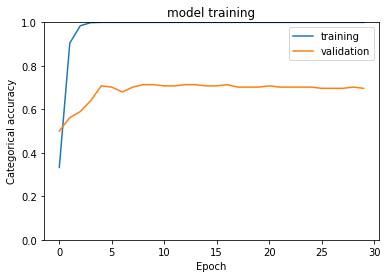

In [33]:
plot_training(history, 0, 1)

### LSTM model

In [113]:
import gensim
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, LSTM, Embedding

First we load and clean the data

In [49]:
X, y = load_data()
X = list(map(text_prepare, X))
y = pd.get_dummies(y) # convert y to one hot vectors

Now transform the words into the pretrained word2vec embeddings obtained from here: https://wikipedia2vec.github.io/wikipedia2vec/pretrained/

In [114]:
# load embeddings, takes a significant amount of time
embedding_file = "enwiki_20180420_win10_100d.txt.bz2"
embedding_size = 100
word_embedder = gensim.models.KeyedVectors.load_word2vec_format(embedding_file, binary=False)

KeyboardInterrupt: 

In [50]:
# transform dataset, doesn't take as long but will eat a few gigs of ram
dummy = np.zeros(embedding_size)
X_embedded = []
for video_comments in X:
    X_embedded.append([])
    for word in video_comments.split(" "):
        try:
            embedding = word_embedder.get_vector(word.lower())
        except KeyError: # not in the embeddings
            embedding = dummy
        X_embedded[-1].append(embedding)

In [64]:
print(len(X_embedded), len(X_embedded[2]))
print(len(X), len(X[2].split(" ")))
X_embedded[0][4000]

890 1478
890 1478


array([-0.564 , -0.5716,  0.1391,  0.1087,  0.3961, -0.4121, -0.4644,
       -0.3132, -0.1375,  0.2368, -0.2153, -0.4151, -0.1271,  0.5038,
       -0.2162,  0.032 ,  0.5347, -0.4009, -0.3393, -0.3071, -0.2252,
       -0.221 ,  0.1205,  0.2257, -0.1878,  0.1841,  0.4495, -0.2308,
        0.0757,  0.0752,  0.5288,  0.4406,  0.2842,  0.0872,  0.1878,
       -0.0744,  0.2577,  0.2439,  0.2827, -0.0337, -0.1579, -0.362 ,
       -0.3085,  0.0963,  0.2978,  0.0941,  0.3881, -0.2976, -0.1492,
        0.0589, -0.2725,  0.1134, -0.1209, -0.3495, -0.3261,  1.1247,
        0.968 , -0.1227, -0.4351, -0.3146,  0.3193, -0.3559, -0.2407,
       -0.6482, -0.3129, -0.7203,  0.0791,  0.2891,  0.146 , -0.2042,
       -0.6314, -0.4798, -0.3662, -0.2042, -0.3436,  0.3492,  0.4094,
       -0.0641,  0.0525,  0.0728, -0.4157,  0.4037, -0.5495, -0.053 ,
        0.1594, -0.1299,  0.5141, -0.1742,  0.0404,  0.0076,  0.119 ,
        0.3242, -0.7302,  0.7806, -0.5962, -0.3785, -0.2235, -0.3008,
        0.2354,  0.7

having the same sequence length is necessary for batching, lets examine the number of words in the comment section of each video

3099.919943820225


(array([194., 302., 135.,  40.,  18.,  15.,   5.,   1.,   1.,   1.]),
 array([   78. ,  1787.9,  3497.8,  5207.7,  6917.6,  8627.5, 10337.4,
        12047.3, 13757.2, 15467.1, 17177. ]),
 <a list of 10 Patch objects>)

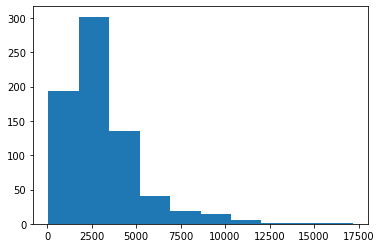

In [126]:
words_per_video = list(map(len, X_train))
print(np.mean(words_per_video))
plt.hist(words_per_video)

Now we need to create our dataset, 3000 words is too much for an LSTM so I'll first try 400

### Create Dataset

Most of the dataset has already been created, we just need to cut off each sample to sample_length

In [ ]:
# truncuate (and pad) a sample so that it has length of "length"
def truncate_sample(words, length):
    words = words[:length]
    while len(words) < length:
        words.append(dummy)
    return words

In [139]:
sample_length = 400
X_training = list(map(lambda x: truncate_sample(x, sample_length), X_embedded))
X_training = np.array(X_training) # tensorflow doesn't like non np data for some reason
X_train, X_test, y_train, y_test = train_test_split(X_training, y, test_size = 0.2)

Create a Bidirectional LSTM which should handle the longer sequences better

In [140]:
model = tf.keras.Sequential()
model.add(Bidirectional(LSTM(50, activation='tanh', dropout=0.2, recurrent_dropout=0.2, input_shape = (None, sample_length, embedding_size))))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['CategoricalAccuracy'])

In [141]:
# train model
history = model.fit(X_train, y_train,
     batch_size = 8, epochs = 50,
     validation_data = (X_test, y_test))

Epoch 1/50
89/89 [==============================] - 71s 796ms/step - loss: 2.2914 - categorical_accuracy: 0.1503 - val_loss: 2.2423 - val_categorical_accuracy: 0.1854
Epoch 2/50
89/89 [==============================] - 65s 729ms/step - loss: 2.0746 - categorical_accuracy: 0.2767 - val_loss: 2.2259 - val_categorical_accuracy: 0.2191
Epoch 3/50
89/89 [==============================] - 63s 713ms/step - loss: 1.9293 - categorical_accuracy: 0.3441 - val_loss: 2.2007 - val_categorical_accuracy: 0.2640
Epoch 4/50
89/89 [==============================] - 68s 767ms/step - loss: 1.8161 - categorical_accuracy: 0.3876 - val_loss: 1.9195 - val_categorical_accuracy: 0.2921
Epoch 5/50
89/89 [==============================] - 69s 780ms/step - loss: 1.7039 - categorical_accuracy: 0.4326 - val_loss: 2.0620 - val_categorical_accuracy: 0.2584
Epoch 6/50
89/89 [==============================] - 62s 701ms/step - loss: 1.7053 - categorical_accuracy: 0.4326 - val_loss: 2.0288 - val_categorical_accuracy: 0.337

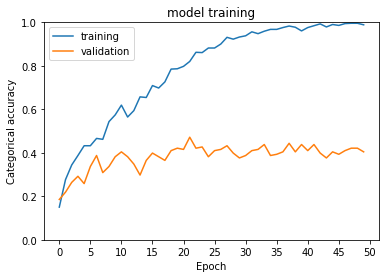

In [144]:
plot_training(history, 0, 1)

### Archive of Dead Code

In [ ]:
# this doesn't work because gensim is an old library and returns a keras layer, not a tf.keras layer, which ruins everything
embedding_layer = word_embedder.get_keras_embedding(train_embeddings=True)
print(type(embedding_layer))
index2entity = word_embedder.index2entity
model = keras.Sequential()
model.add(embedding_layer)
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['CategoricalAccuracy'])

In [12]:
# these functions create a dataset for an LSTM that trains its own embeddings, which isn't our approach anymore
# create a function that creates the LSTM dataset
def lstm_dataset(X_train, X_test, sequence_length, max_words):
    tokenizer = Tokenizer(num_words = max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train)
    X_train = tokenize_text(X_train, tokenizer, sequence_length)
    X_test = tokenize_text(X_test, tokenizer, sequence_length)
    return X_train, X_test
    
# function that tokenizes and pads text
def tokenize_text(text, tokenizer, sequence_length):
    tokens = tokenizer.texts_to_sequences(text)
    tokens = pad_sequences(tokens, maxlen=sequence_length, padding='post', truncating='post')
    return tokens